## **Semantic Segmentation**
ใน Notebook นี้เราจะมาลงมือทดลองสร้างและเทรนโมเดลสำหรับจำแนกประเภทของพิกเซลเบื้องต้นด้วยไลบรารี่ Icevision และ fastai

Taken from [AI builders' repository](https://github.com/ai-builders/curriculum/blob/main/notebooks/05v_semantic_segmentation.ipynb)

**Authored by**: Titipat

Install icevision จาก source code ของ icevision
(คำสั่งต่อไปนี้จะ  restart notebook เพื่อให้มีการใช้งาน icevision ที่เพิ่งติดตั้งได้)

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
!bash icevision_install.sh cuda11

# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
from icevision.all import *

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

โหลด dataset สำหรับ Semantic Segmentation จาก "icedata"

In [ ]:
data_url = 'https://s3.amazonaws.com/fast-ai-sample/camvid_tiny.tgz'
data_dir = icedata.load_data(data_url, 'camvid_tiny') / 'camvid_tiny'

  0%|          | 0/2314212 [00:00<?, ?B/s]

In [ ]:
codes = np.loadtxt(data_dir/'codes.txt', dtype=str)
class_map = ClassMap(list(codes))

In [ ]:
class_map

<ClassMap: {'background': 0, 'Animal': 1, 'Archway': 2, 'Bicyclist': 3, 'Bridge': 4, 'Building': 5, 'Car': 6, 'CartLuggagePram': 7, 'Child': 8, 'Column_Pole': 9, 'Fence': 10, 'LaneMkgsDriv': 11, 'LaneMkgsNonDriv': 12, 'Misc_Text': 13, 'MotorcycleScooter': 14, 'OtherMoving': 15, 'ParkingBlock': 16, 'Pedestrian': 17, 'Road': 18, 'RoadShoulder': 19, 'Sidewalk': 20, 'SignSymbol': 21, 'Sky': 22, 'SUVPickupTruck': 23, 'TrafficCone': 24, 'TrafficLight': 25, 'Train': 26, 'Tree': 27, 'Truck_Bus': 28, 'Tunnel': 29, 'VegetationMisc': 30, 'Void': 31, 'Wall': 32}>

In [ ]:
images_dir = data_dir/'images'
labels_dir = data_dir/'labels'
image_files = get_image_files(images_dir)

In [ ]:
records = RecordCollection(SemanticSegmentationRecord)

for image_file in pbar(image_files):
    record = records.get_by_record_id(image_file.stem)

    if record.is_new:
        record.set_filepath(image_file)
        record.set_img_size(get_img_size(image_file))
        record.segmentation.set_class_map(class_map)

    mask_file = SemanticMaskFile(labels_dir / f'{image_file.stem}_P.png')
    record.segmentation.set_mask(mask_file)

records = records.autofix()
train_records, valid_records = records.make_splits(RandomSplitter([0.8, 0.2]))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

ลองดู data ของเรา

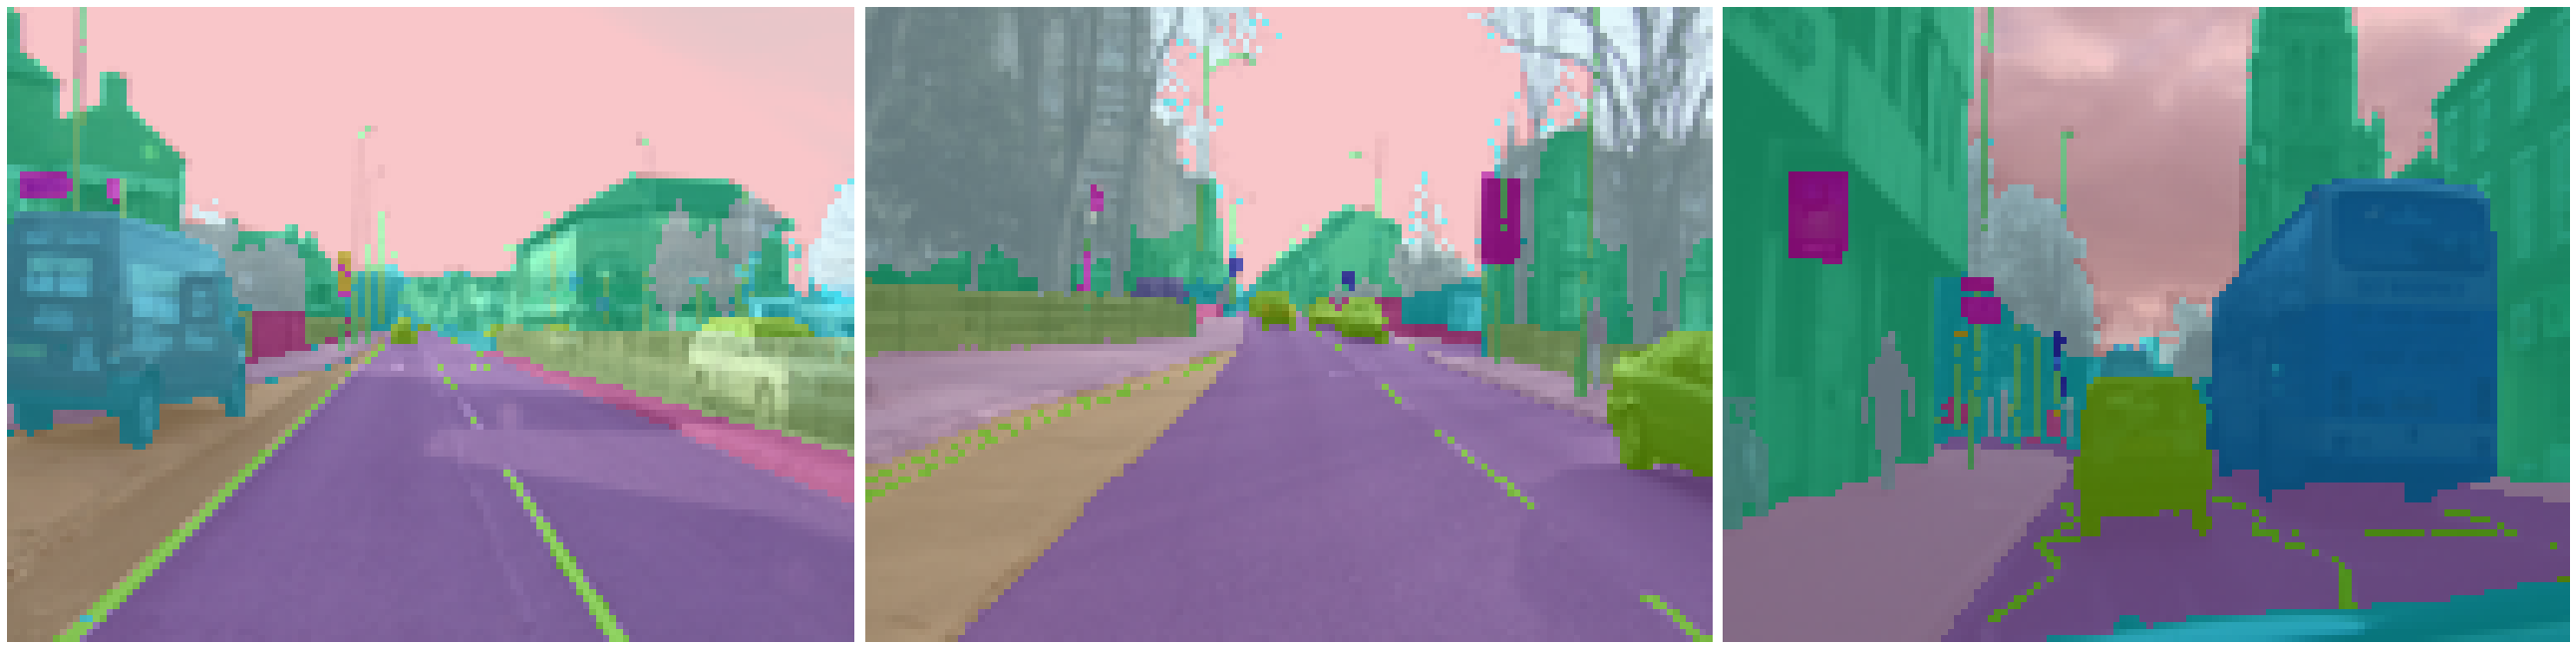

In [ ]:
sample_records = random.choices(records, k=3)
show_records(sample_records, ncols=3)

In [ ]:
# กำหนด transformations และ augmentations ต่างๆ
presize, size = 512, 384
presize, size = ImgSize(presize, int(presize*.75)), ImgSize(size, int(size*.75))

aug_tfms = tfms.A.aug_tfms(
    presize=presize, size=size, pad=None,
    crop_fn=partial(tfms.A.RandomCrop, p=0.5),
    shift_scale_rotate=tfms.A.ShiftScaleRotate(rotate_limit=2),
)
train_tfms = tfms.A.Adapter([*aug_tfms, tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.resize(size), tfms.A.Normalize()])

In [ ]:
# สร้าง Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

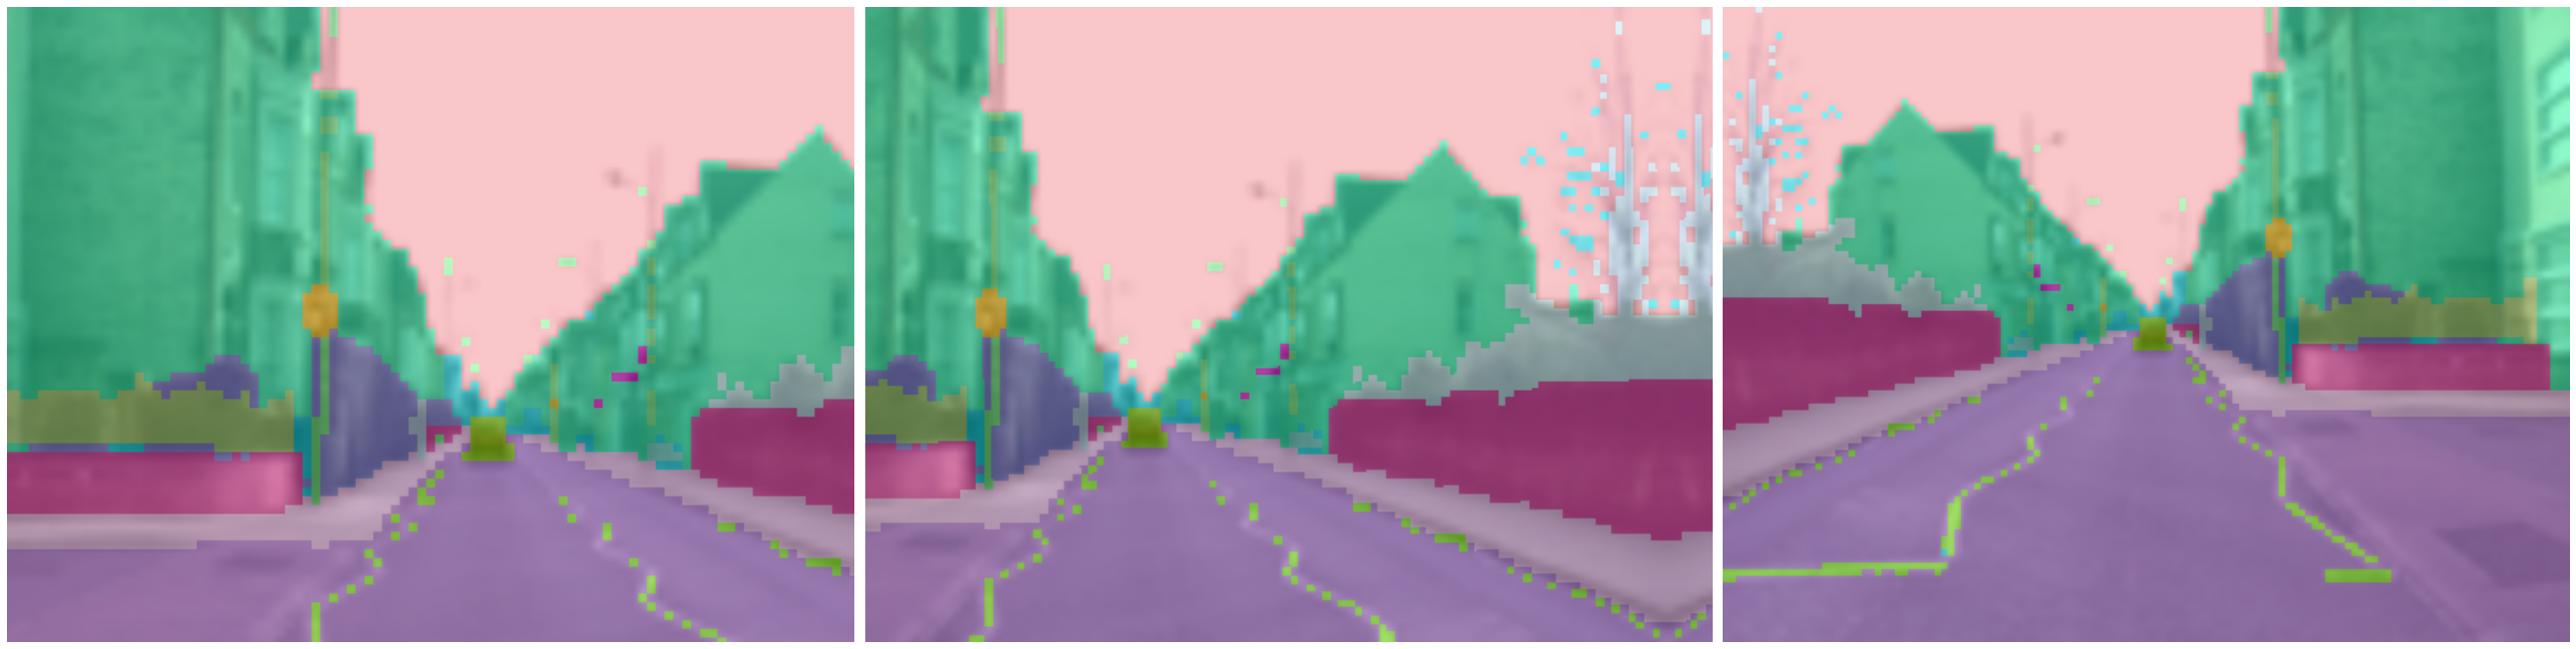

In [ ]:
# ทดสอบอีกครั้งว่า Dataset ของเราสามารถโหลดรูปภาพและ label มาได้หรือไม่
ds_samples = [train_ds[0] for _ in range(3)]
show_samples(ds_samples, ncols=3)

In [ ]:
# สร้าง dataloaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=1, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=1, shuffle=False)

In [ ]:
model_type = models.fastai.unet # ใช้ unet จาก fastai เป็น model หลัก
backbone = model_type.backbones.resnet34() # ใช้ resnet34 จาก fastai เป็น backbone

model = model_type.model(
    backbone=backbone,
    num_classes=class_map.num_classes,
    img_size=size
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### **Peeking inside the Dataloader**

In [ ]:
img, _ = next(iter(train_dl))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
img[0].shape, img[1].shape

(torch.Size([8, 3, 288, 384]), torch.Size([8, 288, 384]))

In [ ]:
pred_img = model(img[0])

In [ ]:
pred_img.shape

torch.Size([8, 33, 288, 384])

### **Training the model**

In [ ]:
def accuracy_camvid(pred, target):
    # ignores void pixels
    keep_idxs = target != class_map.get_by_name('Void')
    target = target[keep_idxs]
    pred = pred.argmax(dim=1)[keep_idxs]

    return (pred==target).float().mean() 

In [ ]:
learner = model_type.fastai.learner(
    dls=[train_dl, valid_dl],
    model=model,
    metrics=[accuracy_camvid]
)

SuggestedLRs(valley=5.248074739938602e-05)

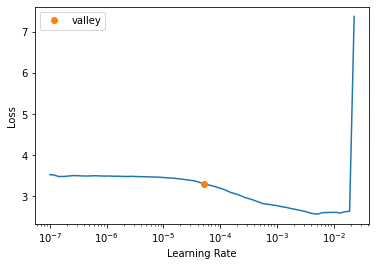

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(30, 5e-4, freeze_epochs=3) # เทรนโดยที่จะปรับเปลี่ยน weights ของ model หลัง epoch ที่ 3

epoch,train_loss,valid_loss,accuracy_camvid,time
0,3.044289,2.695424,0.381433,00:12
1,2.502741,1.931275,0.562028,00:09
2,2.117187,1.440727,0.652397,00:09


epoch,train_loss,valid_loss,accuracy_camvid,time
0,1.246455,1.273080,0.664605,00:09
1,1.204966,1.186616,0.684556,00:09
2,1.168549,1.107735,0.707044,00:09
3,1.114910,1.026837,0.724841,00:09
4,1.067286,0.998844,0.739961,00:09
5,1.056805,1.045689,0.709671,00:09
6,1.038498,1.012202,0.753599,00:09
7,0.991902,0.920844,0.767707,00:09
8,0.965852,0.868546,0.766876,00:09
9,0.927975,0.800994,0.789207,00:09


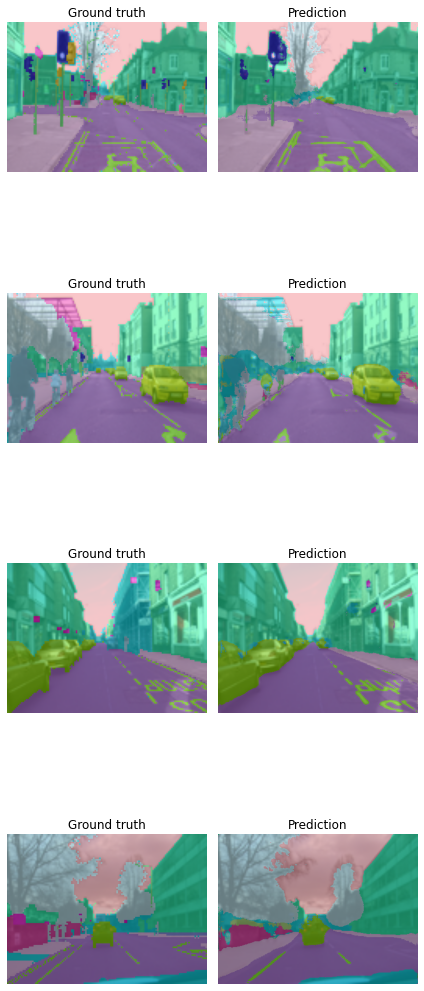

In [ ]:
# example predictions
model_type.show_results(model, valid_ds, num_samples=4)